# Utils

In [2]:
from lib.data.metainfo import MetaInfo
from lib.data.transforms import BaseTransform
import hydra
from lib.utils.config import load_config
import matplotlib.pyplot as plt
import torch
from lib.data.transforms import BaseTransform, DilateSketch, SketchTransform, ToSketch
from torchvision.transforms import v2
from lib.data.metainfo import MetaInfo
from lib.data.transforms import BaseTransform
import hydra
from lib.utils.config import load_config
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import l1_loss
import cv2 as cv
import numpy as np


def plot_images_np(images, size: int = 4):
    if isinstance(images, list):
        _, axes = plt.subplots(1, len(images), figsize=(size, size))
        for ax, image in zip(axes, images):
            ax.imshow(image)
            ax.axis("off")  # Turn off axis
        plt.show()
    else:
        plt.figure(figsize=(size, size))
        plt.imshow(images)
        plt.show()


def plot_images(images, size: int = 4):
    if isinstance(images, list):
        _, axes = plt.subplots(1, len(images), figsize=(size, size))
        for ax, image in zip(axes, images):
            ax.imshow(image.detach().cpu().numpy())
            ax.axis("off")  # Turn off axis
        plt.show()
    else:
        plt.figure(figsize=(size, size))
        plt.imshow(images.detach().cpu().numpy())
        plt.show()


cfg = load_config("optimize_sketch", ["+dataset=shapenet_chair_4096"])
cfg.loss_ckpt_path = f"{cfg.paths.checkpoint_dir}/latent_traverse.ckpt"
metainfo = MetaInfo(cfg.data.data_dir)
sketch_transform = SketchTransform(kernel_size=3, normalize=False)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Traversal Dataset

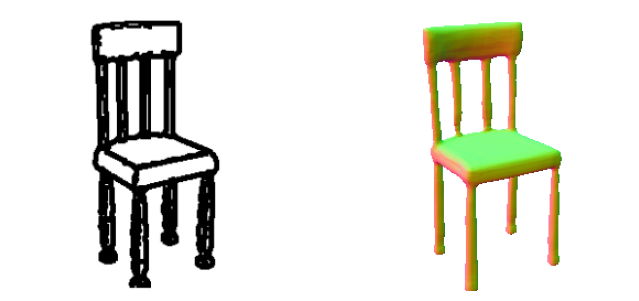

In [2]:
cfg.model.prior_obj_id = metainfo.obj_ids[0]
cfg.model.prior_mode = 0
model = hydra.utils.instantiate(cfg.model).to("cuda")
source_id = 0
sketch = metainfo.load_image(source_id, 34, 0)

# for i in torch.randint(4096, (100,)):
for i in torch.randint(4096, (10,)):
    t = torch.normal(torch.tensor(0.25), torch.tensor(0.1))
    t = torch.clamp(t, 0.0, 0.5)
    azim = 30
    elev = -20
    model.deepsdf.create_camera(azim=azim, elev=elev)
    target_id = i

    source_latent = model.deepsdf.lat_vecs.weight[source_id]
    model.latent = source_latent
    source_normal = model.capture_camera_frame().detach().cpu().numpy()

    target_latent = model.deepsdf.lat_vecs.weight[target_id]
    model.latent = target_latent
    target_normal = model.capture_camera_frame().detach().cpu().numpy()

    interpolated_latent = (1 - t) * source_latent + t * target_latent
    model.latent = interpolated_latent
    interpolated_normal = model.capture_camera_frame().detach().cpu().numpy()

    plot_images_np(
        [
            sketch_transform(sketch).permute(1, 2, 0),
            interpolated_normal
        ],
        size=8,
    )
    break

# Silhouette Masks

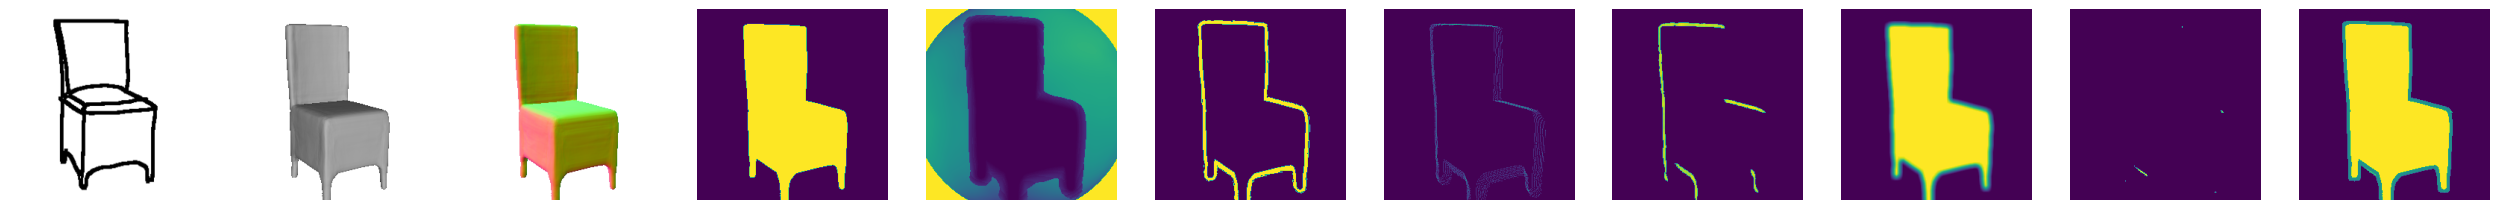

In [13]:
obj_label = 4231   # 10, 4112, (4117), 12, 13, 4152
azim = 30
elev = -10

# create sketch
img = metainfo.load_image(obj_label, 0, 10)
# img = metainfo.load_image(obj_label, 6, 9)
transforms = [v2.Resize((256, 256)), ToSketch(), DilateSketch(kernel_size=3)]
to_image = BaseTransform(normalize=False, transforms=transforms)
sketch = to_image(img).permute(1, 2, 0)

# setup model
cfg.model.prior_mode = 0
cfg.model.prior_obj_id = metainfo.obj_ids[obj_label]
cfg.model.latent_init = "latent"
model = hydra.utils.instantiate(cfg.model).to("cuda")
model.deepsdf.create_camera(azim=azim, elev=elev)


with torch.no_grad():
    points, surface_mask = model.deepsdf.sphere_tracing(
        latent=model.latent,
        points=model.deepsdf.camera_points,
        mask=model.deepsdf.camera_mask,
        rays=model.deepsdf.camera_rays,
    )
    normals = model.deepsdf.render_normals(
        points=points,
        latent=model.latent,
        mask=surface_mask,
    )
    grayscale = model.deepsdf.render_grayscale(
        points=points,
        latent=model.latent,
        mask=surface_mask,
    )
    # grayscale = model.deepsdf.normals_to_grayscales(normals)
    silhouette = model.deepsdf.render_silhouette(
        normals=normals,
        points=points,
        latent=model.latent,
        proj_blur_eps=0.7,
        weight_blur_kernal_size=9,
        weight_blur_sigma=9.0,
    )
plot_images(
    [
        sketch,
        grayscale,
        normals,
        silhouette["base_silhouette"],
        silhouette["min_sdf"],
        silhouette["extra_silhouette"],
        silhouette["proj_silhouette"],
        silhouette["proj_blur_silhouette"],
        silhouette["base_blur_silhouette"],
        silhouette["weighted_silhouette"],
        silhouette["final_silhouette"],
    ],
    size=32,
)

# View Robustness

In [ ]:
# TODO

# Qualitative Hand Drawn

In [ ]:
# TODO